### Imports

### Thresholding 

*Last Updated*: 2023-06-29

### Authors
* Hannah Zhang (hannahzhang@ucsb.edu)


### Overview
This Jupyter notebook is intended to demonstrate 

* generating hand outline
* thresholding
* edge detection


### Key Results

- hand outline can be used for testing if hand shape is correlated to age
- thresholding and edge detection can be used for defining wrinkles


In [154]:
import os
import cv2
import glob
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from rembg import remove
#import easygui
from PIL import Image
from numpy import asarray
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.filters import gabor
from skimage import io


### Prepare Data

In [155]:
#load sample images
images = []
def load_images(foldername):
    for filename in os.listdir(foldername):
        if filename == ".DS_Store":
            continue
        input = Image.open(os.path.join(foldername,filename))
        print(filename)
        
        if input is not None:
            images.append(input)
    return images
img_list = load_images("/Users/hannahzhang/Downloads/test_ims/")

16B45EFF-7F1D-4437-B8FA-C7D4ADBF4F92.jpeg
7F301A45-1207-4B6A-A05A-72B320B25E95.jpeg
6C550AAE-8181-41AA-829C-B42D255A9E2F.jpeg
5A7E3A5F-334A-4C8D-9E0D-BD435389C81E.jpeg
image007.jpg
E4FE4EBA-68AA-434C-8260-54646D0C4AC3.jpeg


### REMBG (Background Removal)

In [10]:
removed_ims = []

for im in images:
    output = remove(im)
    numpydata = asarray(output)
    removed_ims.append(numpydata)

### Feature Extraction - Hand Outline

In [4]:
processed_ims = []   

for im in removed_ims:
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Apply edge detection to find the border
    edges = cv2.Canny(gray, 0,30)

    # Dilate the edges to connect any gaps
    dilated_edges = cv2.dilate(edges, None, iterations=5)

    # dilated_ims.append(dilated_edges)

    gray = cv2.cvtColor(dilated_edges, cv2.COLOR_GRAY2BGR)

    # Define the lower and upper thresholds for purple and yellow intensities
    lower_purple = 100
    upper_purple = 150
    lower_yellow = 160
    upper_yellow = 210

    # Create masks for purple and yellow intensities
    purple_mask = cv2.inRange(gray, lower_purple, upper_purple)
    yellow_mask = cv2.inRange(gray, lower_yellow, upper_yellow)

    # Find contours for purple and yellow regions
    if cv2.__version__.startswith('4'):
        contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        purple_contours = contours
        contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        yellow_contours = contours
    else:
        _, purple_contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        _, yellow_contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the image
    cv2.drawContours(gray, purple_contours, -1, (255, 0, 0), thickness=2)
    cv2.drawContours(gray, yellow_contours, -1, (0, 255, 255), thickness=2)

    # Find the centroids of the contours
    if len(purple_contours) > 0:
        purple_centroid = np.mean([c[0] for c in purple_contours], axis=0)
        purple_centroid = purple_centroid.astype(int)
    if len(yellow_contours) > 0:
        yellow_centroid = np.mean([c[0] for c in yellow_contours], axis=0)
        yellow_centroid = yellow_centroid.astype(int)

    # Draw a line connecting the centroids
    if len(purple_contours) > 0 and len(yellow_contours) > 0:
        cv2.line(gray, tuple(purple_centroid), tuple(yellow_centroid), (0, 255, 0), thickness=2)

    processed_ims.append(gray)

    

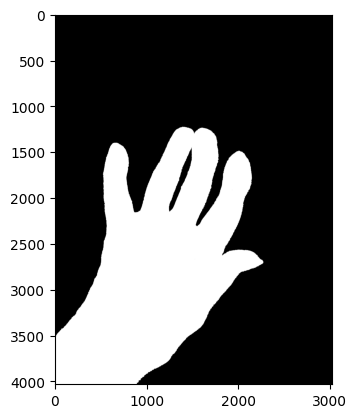

In [153]:
plt.imshow(processed_ims[0])

### Feature Vector Creation

VGG16

In [69]:
# Load pre-trained VGG16 model
vg_model = VGG16(weights='imagenet', include_top=False)

vg_feature_vectors = []
# Load and preprocess the image
for im in processed_ims:
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    vg_features = vg_model.predict(x)

    # Flatten or pool the features
    vg_flattened_features = vg_features.flatten()

    # Normalize the feature vector
    vg_normalized_features = vg_flattened_features / np.linalg.norm(vg_flattened_features)

    vg_feature_vectors.append(vg_normalized_features)

    print(vg_feature_vectors[0].shape)

1/1 [==============================] - 16s 16s/step
(6064128,)
1/1 [==============================] - 11s 11s/step
(6064128,)
1/1 [==============================] - 11s 11s/step
(6064128,)
1/1 [==============================] - 17s 17s/step
(6064128,)
1/1 [==============================] - 17s 17s/step
(6064128,)
1/1 [==============================] - 15s 15s/step
(6064128,)


ResNet50

In [68]:
resnet_model = ResNet50(weights='imagenet', include_top=True)

res_feature_vectors =[]

# Load and preprocess the image
for im in processed_ims:
    im = np.resize(im, (224, 224, 3)) 
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    res_features = resnet_model.predict(x)

    # Flatten or pool the features
    res_flattened_features = res_features.flatten()

    # Normalize the feature vector
    res_normalized_features = res_flattened_features / np.linalg.norm(res_flattened_features)

    res_feature_vectors.append(res_normalized_features)

    print(res_feature_vectors[0].shape)

1/1 [==============================] - 0s 378ms/step
(1000,)
1/1 [==============================] - 0s 59ms/step
(1000,)
1/1 [==============================] - 0s 60ms/step
(1000,)
1/1 [==============================] - 0s 56ms/step
(1000,)
1/1 [==============================] - 0s 54ms/step
(1000,)
1/1 [==============================] - 0s 51ms/step
(1000,)


### Pipeline Component Development #2

### Feature Extraction - Wrinkles

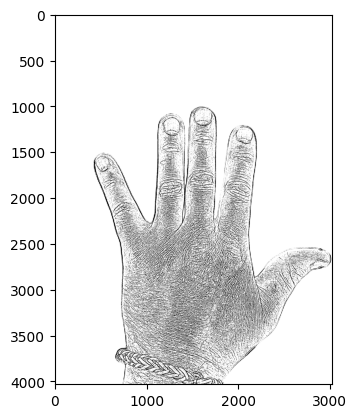

In [34]:
thresh_ims = []

for im in removed_ims:
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, 2)

    RGB_thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_thresh)

    thresh_ims.append(RGB_thresh)

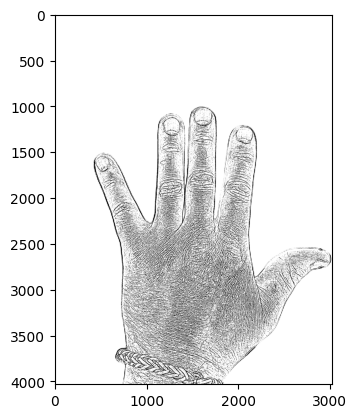

In [55]:
plt.imshow(thresh_ims[5])

Finger Shape

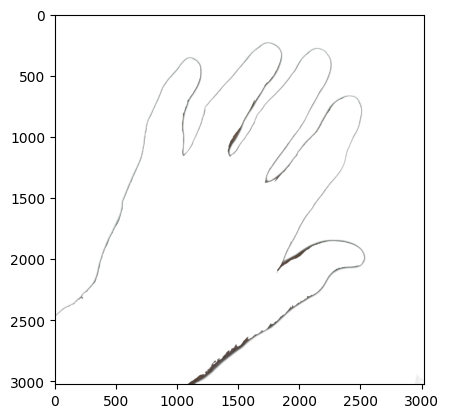

In [147]:
fingers = []

for im in removed_ims:
    #convert image to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding to create a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and extract finger contours based on area and aspect ratio
    finger_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)
        if aspect_ratio > 0.3 and area > 1000000:
            finger_contours.append(contour)

    # Create a mask for finger contours
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, finger_contours, -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original image to obtain the cropped image
    cropped_image = cv2.bitwise_and(im, im, mask=mask)
    fingers.append(cropped_image)

plt.imshow(fingers[2])

# # Display the cropped image
# cv2.imshow('Cropped Image', cropped_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Wrinkles Using Edge Detection

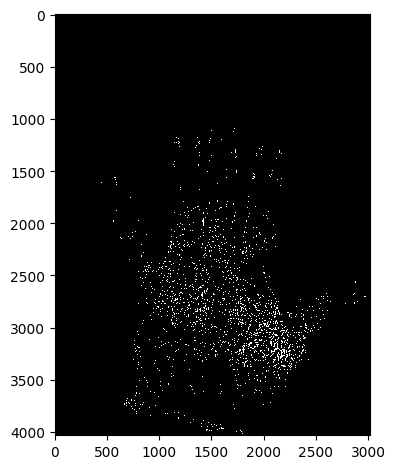

In [151]:
for im in removed_ims:
    arr = np.array(im)
    opencvim = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)

# detecting edges in hand images
filt_real, filt_imag = gabor(opencvim, frequency=0.2)
plt.figure()            
io.imshow(filt_real)    
io.show()  